In [ ]:
!pip install torch torchvision scikit-learn matplotlib timm tqdm Pillow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/My Drive/COGS181-FinalProject'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/COGS181-FinalProject


In [ ]:
import os
import glob
import random
import timm
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from tqdm import tqdm
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.cuda.amp import autocast, GradScaler

## Loading and Pre-processing Images for CNN (Xception)

In [ ]:
# Assign Paths

base_dir = "/content/drive/My Drive/COGS181-FinalProject"

real_faces_dir = os.path.join(base_dir, "Real_Faces")
ai_faces_dir   = os.path.join(base_dir, "AI_Faces")

real_faces = glob.glob(os.path.join(real_faces_dir, "*.png"))
ai_faces   = glob.glob(os.path.join(ai_faces_dir, "*.png"))

# Assign Binary Labels: [0 -> Real_Faces] [1 -> AI_Faces]

real_labels = [0] * len(real_faces)
ai_labels   = [1] * len(ai_faces)

all_paths  = real_faces + ai_faces
all_labels = real_labels + ai_labels

print(f"Found {len(real_faces)} images of Real (Actual) Human Faces.")
print(f"Found {len(ai_faces)} images of AI Generated Human Face.")

Found 10000 images of Real (Actual) Human Faces.
Found 10000 images of AI Generated Human Face.


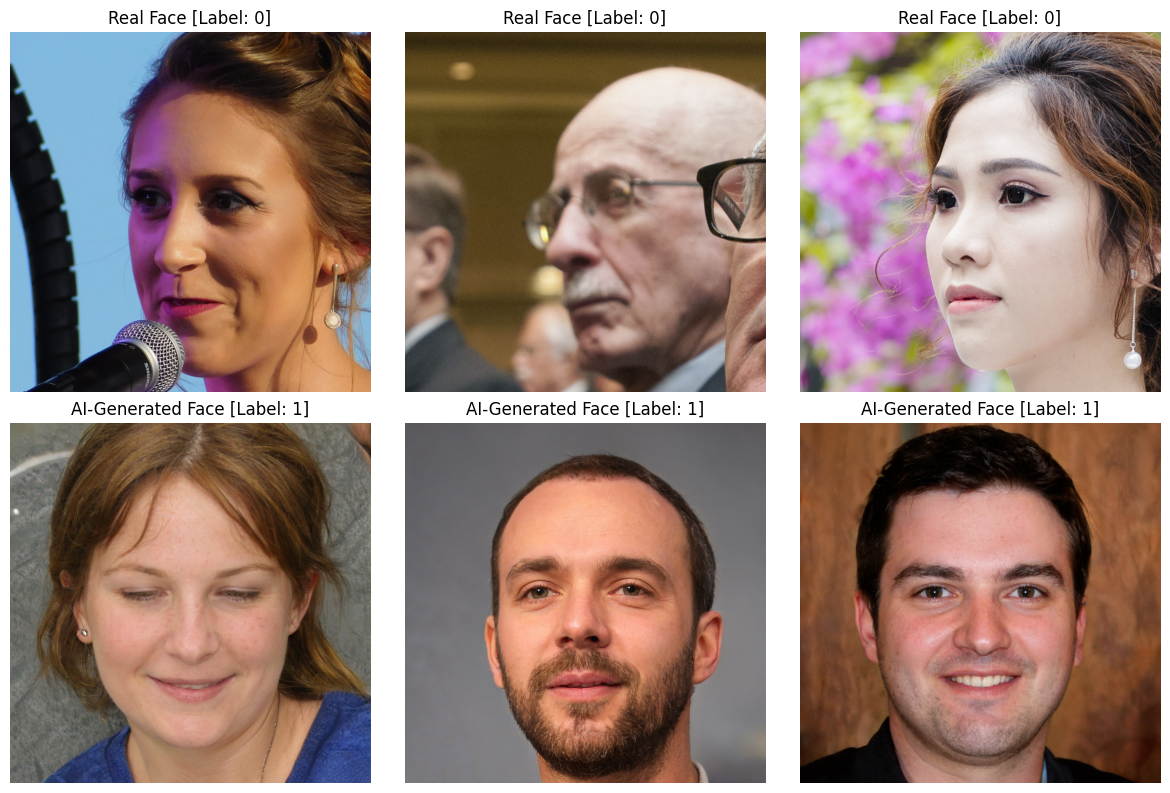

In [ ]:
# Visualize Randomly Sampled Images

num_real = 3
num_ai = 3

real_sample_paths = random.sample(real_faces, num_real)
ai_sample_paths = random.sample(ai_faces, num_ai)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

for i, path in enumerate(real_sample_paths):
    image = Image.open(path).convert("RGB")
    axes[0, i].imshow(image)
    axes[0, i].set_title("Real Face [Label: 0]")
    axes[0, i].axis("off")

for i, path in enumerate(ai_sample_paths):
    image = Image.open(path).convert("RGB")
    axes[1, i].imshow(image)
    axes[1, i].set_title("AI-Generated Face [Label: 1]")
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
# Split Data into Train/Val/Test (80/10/10)

train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    all_paths,
    all_labels,
    test_size=0.2,
    stratify=all_labels,
    random_state=42
)

val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths,
    temp_labels,
    test_size=0.5,
    stratify=temp_labels,
    random_state=42
)

print(f"Training Dataset   : {len(train_paths)} images")
print(f"\nValidation Dataset : {len(val_paths)} images")
print(f"\nTest Dataset       : {len(test_paths)} images")

Training Dataset   : 16000 images

Validation Dataset : 2000 images

Test Dataset       : 2000 images


In [ ]:
# Data Augmentation & Pre-processing

class FaceDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Define Optimized Parameters for CNN Model (Xception)

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

# TRAIN (Augmentation + Normalization)

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(299, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

# VAL (Augmentation + Normalization)

val_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

# TEST (Augmentation + Normalization)

test_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

# DataLoader Setup

train_dataset = FaceDataset(train_paths, train_labels, transform=train_transform)
val_dataset   = FaceDataset(val_paths,   val_labels,   transform=val_transform)
test_dataset  = FaceDataset(test_paths,  test_labels,  transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=6, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=6, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=6, pin_memory=True)

print("DataLoaders created for training, validation, and testing datasets.")

DataLoaders created for training, validation, and testing datasets.


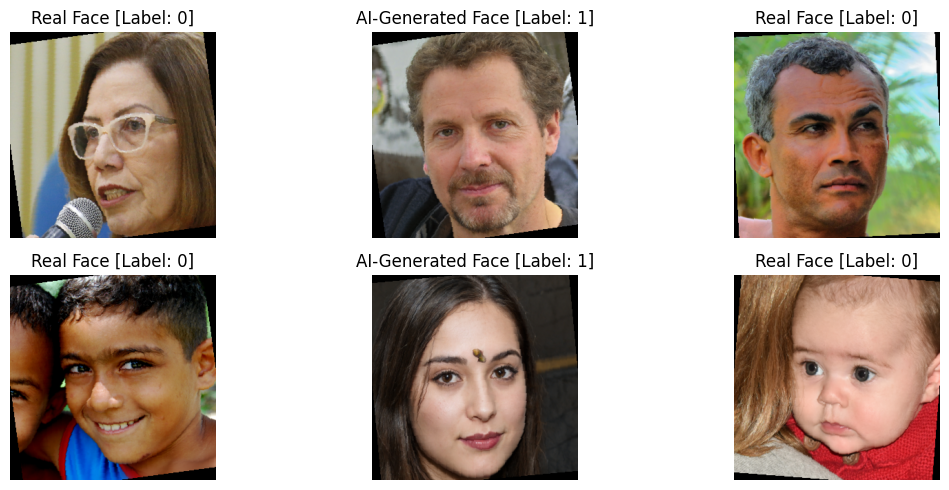

In [ ]:
def denormalize_img(tensor, mean, std):
    img = tensor.cpu().numpy().transpose(1, 2, 0)
    img = (img * std) + mean
    img = np.clip(img, 0, 1)
    return img

def visualize_preprocessed_batch(dataloader, mean, std, num_images=6):
    data_iter = iter(dataloader)
    images, labels = next(data_iter)

    images = images[:num_images]
    labels = labels[:num_images]

    ncols = min(3, num_images)
    nrows = (num_images + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 5))

    axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

    for i in range(num_images):
        denorm_img = denormalize_img(images[i], np.array(mean), np.array(std))
        axes[i].imshow(denorm_img)
        axes[i].set_title("Real Face [Label: 0]" if labels[i].item() == 0 else "AI-Generated Face [Label: 1]")
        axes[i].axis("off")

    for j in range(num_images, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

visualize_preprocessed_batch(train_loader, IMAGENET_MEAN, IMAGENET_STD, num_images=6)

## Setting Up CNN Model for Training

In [ ]:
# GPU Setup

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Using device:", device)

scaler = GradScaler()

print("\nInitialized GradScaler for PyTorch AMP (Automatic Mixed Precision).\n")

Using device: cuda

Initialized GradScaler for PyTorch AMP (Automatic Mixed Precision).



<ipython-input-11-2c3816e6da93>:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [ ]:
# Load and Define the CNN Model (Xception)

xception_model = timm.create_model(
    "legacy_xception",
    pretrained=True,
    num_classes=1
)

xception_model = xception_model.to(device)

# Define Binary Cross-Entropy Loss

criterion = nn.BCEWithLogitsLoss()

# Define Optimizer (Adam w/ Weight Decay)

optimizer = optim.Adam(xception_model.parameters(), lr=0.0001, weight_decay=1e-4)

# Define Dynamic Learning Rate Scheduler (CosineAnnealingLR)

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)

print("Model was sucessfully loaded.\n")
print("Model Summary:\n\n", xception_model)

Model was sucessfully loaded.

Model Summary:

 Xception(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): ReLU(inplace=True)
  (block1): Block(
    (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (rep): Sequential(
      (0): SeparableConv2d(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
 

## Training the CNN (Xception)

In [ ]:
# Defining Function for Training Process

def train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    num_epochs=10,
    train_steps_per_epoch=200,
    val_steps_per_epoch=15
):

    print(f"Starting Training for {num_epochs} epochs...\n\n")

    for epoch in range(num_epochs):

        # Training Phase

        model.train()
        running_loss = 0.0
        running_corrects = 0
        total_samples = 0

        train_iter = iter(train_loader)

        with tqdm(total=train_steps_per_epoch, desc=f"Epoch {epoch+1} [Training]", leave=True) as pbar:
            for step in range(train_steps_per_epoch):
                try:
                    images, labels = next(train_iter)
                except StopIteration:
                    train_iter = iter(train_loader)
                    images, labels = next(train_iter)

                images = images.to(device)
                labels = labels.to(device).float()

                optimizer.zero_grad()

                with torch.amp.autocast("cuda"):
                    outputs = model(images)
                    loss = criterion(outputs.squeeze(dim=1), labels)

                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

                running_loss += loss.item() * images.size(0)

                preds = torch.sigmoid(outputs).squeeze(dim=1) >= 0.5
                corrects = (preds == (labels == 1.0)).sum().item()
                running_corrects += corrects
                total_samples += images.size(0)

                pbar.update(1)

        train_epoch_loss = running_loss / total_samples
        train_epoch_acc = (running_corrects / total_samples) * 100.0

        # Validation Phase

        model.eval()
        val_loss = 0.0
        val_corrects = 0
        val_samples = 0

        val_iter = iter(val_loader)

        with torch.no_grad():
            with tqdm(total=val_steps_per_epoch, desc=f"Epoch {epoch+1} [Validation]", leave=True) as pbar:
                for step in range(val_steps_per_epoch):
                    try:
                        images, labels = next(val_iter)
                    except StopIteration:
                        break

                    images = images.to(device)
                    labels = labels.to(device).float()

                    with torch.amp.autocast("cuda"):
                        outputs = model(images)
                        loss = criterion(outputs.squeeze(dim=1), labels)

                    val_loss += loss.item() * images.size(0)

                    preds = torch.sigmoid(outputs).squeeze(dim=1) >= 0.5
                    corrects = (preds == (labels == 1.0)).sum().item()
                    val_corrects += corrects
                    val_samples += images.size(0)

                    pbar.update(1)

        val_epoch_loss = val_loss / val_samples if val_samples > 0 else 0.0
        val_epoch_acc = (val_corrects / val_samples) * 100.0 if val_samples > 0 else 0.0

        scheduler.step()

        print(f"\nEpoch [{epoch+1}/{num_epochs}]")
        print(f"Training Loss: {train_epoch_loss:.4f} | Training Accuracy: {train_epoch_acc:.2f}%")
        print(f"Validation Loss: {val_epoch_loss:.4f} | Validation Accuracy: {val_epoch_acc:.2f}%")
        print("-" * 50)

    print("\nTraining complete!")

print("Model is ready for training.")

Model is ready for training.


In [ ]:
# Training Xception CNN

train_model(
    model=xception_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=10,
    train_steps_per_epoch=200,
    val_steps_per_epoch=15
)

Starting Training for 10 epochs...




Epoch 1 [Validation]: 100%|██████████| 15/15 [00:27<00:00,  1.82s/it]


Epoch [1/10]
Training Loss: 0.1808 | Training Accuracy: 93.00%
Validation Loss: 0.0677 | Validation Accuracy: 97.76%
--------------------------------------------------



Epoch 2 [Validation]: 100%|██████████| 15/15 [00:27<00:00,  1.82s/it]


Epoch [2/10]
Training Loss: 0.0361 | Training Accuracy: 98.78%
Validation Loss: 0.0383 | Validation Accuracy: 98.85%
--------------------------------------------------



Epoch 3 [Validation]: 100%|██████████| 15/15 [00:27<00:00,  1.81s/it]


Epoch [3/10]
Training Loss: 0.0198 | Training Accuracy: 99.39%
Validation Loss: 0.0308 | Validation Accuracy: 98.96%
--------------------------------------------------



Epoch 4 [Validation]: 100%|██████████| 15/15 [00:26<00:00,  1.80s/it]


Epoch [4/10]
Training Loss: 0.0118 | Training Accuracy: 99.61%
Validation Loss: 0.0436 | Validation Accuracy: 98.65%
--------------------------------------------------



Epoch 5 [Validation]: 100%|██████████| 15/15 [00:27<00:00,  1.84s/it]


Epoch [5/10]
Training Loss: 0.0098 | Training Accuracy: 99.69%
Validation Loss: 0.0267 | Validation Accuracy: 99.22%
--------------------------------------------------



Epoch 6 [Validation]: 100%|██████████| 15/15 [00:27<00:00,  1.82s/it]


Epoch [6/10]
Training Loss: 0.0071 | Training Accuracy: 99.76%
Validation Loss: 0.0209 | Validation Accuracy: 99.43%
--------------------------------------------------



Epoch 7 [Validation]: 100%|██████████| 15/15 [00:27<00:00,  1.84s/it]


Epoch [7/10]
Training Loss: 0.0055 | Training Accuracy: 99.81%
Validation Loss: 0.0192 | Validation Accuracy: 99.32%
--------------------------------------------------



Epoch 8 [Validation]: 100%|██████████| 15/15 [00:27<00:00,  1.82s/it]


Epoch [8/10]
Training Loss: 0.0063 | Training Accuracy: 99.77%
Validation Loss: 0.0214 | Validation Accuracy: 99.48%
--------------------------------------------------



Epoch 9 [Validation]: 100%|██████████| 15/15 [00:27<00:00,  1.83s/it]


Epoch [9/10]
Training Loss: 0.0022 | Training Accuracy: 99.95%
Validation Loss: 0.0156 | Validation Accuracy: 99.69%
--------------------------------------------------



Epoch 10 [Validation]: 100%|██████████| 15/15 [00:27<00:00,  1.83s/it]



Epoch [10/10]
Training Loss: 0.0051 | Training Accuracy: 99.82%
Validation Loss: 0.0195 | Validation Accuracy: 99.43%
--------------------------------------------------

Training complete!


In [ ]:
# Saving Trained Model

model_save_path = "/content/drive/My Drive/COGS181-FinalProject/xception_model.pth"
torch.save(xception_model.state_dict(), model_save_path)

print(f"Trained model successfully saved.")

Trained model successfully saved.


## Testing the Trained CNN Model (Xception)

In [ ]:
# Loading Trained CNN Model

xception_model = timm.create_model(
    "legacy_xception",
    pretrained=True,
    num_classes=1
)

xception_model = xception_model.to(device)

# Load Weights

xception_model.load_state_dict(torch.load(model_save_path))

# Set Model to Evaluation Mode

xception_model.eval()

print("Model successfully loaded and ready for testing.")

Model successfully loaded and ready for testing.


In [ ]:
# Testing Trained CNN Model

correct = 0
total = 0

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Evaluating", unit="batch"):
        images, labels = images.to(device), labels.to(device)

        outputs = xception_model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total

print(f"\n\nTest Accuracy: {test_accuracy:.2f}%")

Evaluating: 100%|██████████| 16/16 [00:23<00:00,  1.46s/batch]


Test Accuracy: 50.00%
